Seja o sistema $y(s) = G(s)u(s)$, com $G(s)=\frac{1}{\tau s + 1}$. Arrumando temos:
$\tau y s + y = u$. Transformando para o domínio do tempo: $\tau \dot{y} = - y + u$, ou seja, $\dot{y}=\frac{-y+u}{\tau}$

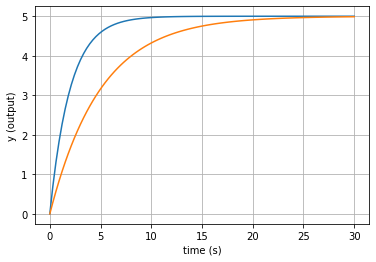

In [2]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def dydt(y, time, u, tau): #yponto
    return (-y + u)/tau

time = np.linspace(0, 30, 100) #T = 5/100 = 0.05 s ou 50 ms h = 0.05 vetor linearmente espaçado
y0 = 0
y1 = odeint(dydt, y0=y0, t=time, args=(5,2)) # u, tau
y2 = odeint(dydt, y0=y0, t=time, args=(5,5))

plt.plot(time, y1, time, y2)
plt.xlabel('time (s)')
plt.ylabel('y (output)')
plt.grid()
plt.show()

tau: 1.0


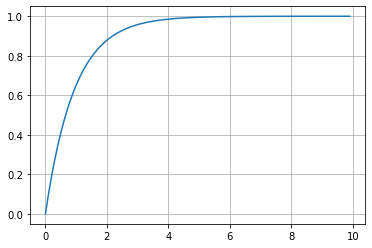

In [19]:
import numpy as np
import matplotlib.pyplot as plt

#método euler backward
tSim = 10
R = 100e3
C = 10e-6
tau = R*C
print('tau: ' + str(tau))

y = []
y.append(0) #condição inicial
t = []
h = 0.1
t.append(0) #parte do tempo = 0

nPontos = round(tSim/h)

u = np.ones(nPontos)
for i in range(1,nPontos):
    y.append(y[i-1] + (h/tau)*(u[i-1] - y[i-1]))
    t.append(t[i-1]+h)

plt.plot(t,y)
plt.grid()

Sistema de segunda ordem - massa/mola

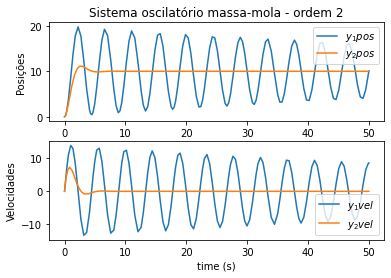

Wall time: 805 ms


In [4]:
%%time
"""
Seja massa m = 0.5 kg
     constante da mola k = 1 N/cm
     coeficiente de amortecimento b = 0.01 N.s/cm
     y/u = 1 / (ms^2+bs+k)
     Por Prof. Josenalde Oliveira - Sistemas Embarcados TADS UFRNt
"""
def massaMola(time,X,m,k,b,u):
    #m = 0.5
    #k = 1
    #b = 0.01 # testar com 0.3 e com 1
    x1,x2 = X
    dotx1 = x2
    dotx2 = (1/m)*(-k*x1-b*x2+u) # u = força externa / sinal de controle
    return dotx1, dotx2

ti = 0
tf = 50
x10,x20=0,0 #assume que a mola esta em repouso x = 0, v = 0

# método de solução de ode Runge-Kutta implícito de ordem 5 RADAU
from scipy import integrate
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html
sol1 = integrate.solve_ivp(massaMola, t_span=(ti, tf), y0=(x10, x20), method='Radau', args=(0.5,1.,0.01,10))
sol2 = integrate.solve_ivp(massaMola, t_span=(ti, tf), y0=(x10, x20), method='Radau', args=(0.5,1.,0.8,10))
t1, Y1 = sol1.t, sol1.y
t2, Y2 = sol2.t, sol2.y

# Separando as soluções y1 é y, y2 é dot_y
y1_pos, y1_vel = Y1 # y1 posicao, y2 velocidade
y2_pos, y2_vel = Y2 # y1 posicao, y2 velocidade

plt.figure(1)
plt.subplot(211)
plt.plot(t1, y1_pos, label=r'$y_1pos$')
plt.plot(t2, y2_pos, label=r'$y_2pos$')
plt.legend()
plt.xlabel('time (s)')
plt.title('Sistema oscilatório massa-mola - ordem 2')
plt.ylabel('Posições')
plt.subplot(212)
plt.plot(t1, y1_vel, label=r'$y_1vel$')
plt.plot(t2, y2_vel, label=r'$y_2vel$')

plt.legend()
plt.xlabel('time (s)')
plt.ylabel('Velocidades')
plt.show()



Raízes de polinômios com <code>numpy</code>. Vetor com os coeficientes para o método roots

In [2]:
import numpy as np
d1 = [0.5, 0.01, 1]
print(np.roots(d1))
d2 = [0.5, 0.3, 1]
print(np.roots(d2))
d3 = [1, 0.4255, 3.1289]
print(np.roots(d3))

[-0.01+1.41417821j -0.01-1.41417821j]
[-0.3+1.3820275j -0.3-1.3820275j]
[-0.21275+1.75602888j -0.21275-1.75602888j]


O Sistema com denominador d1 possui raízes mais próximas do eixo imaginário, portanto, mais oscilatório

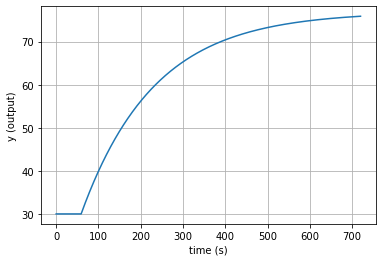

In [9]:

######################################################
# FOPDT model                                        #
######################################################
Kp = 0.67      # degC/%
tauP = 172.3  # seconds
thetaP = 29.15   # seconds (integer)
Tss = 30      # degC (ambient temperature)
Qss = 0       # % heater
dt = 1 #1s
Tpl = []
Tpl.append(30) # primeira temperatura lida, assumindo ser a ambiente TSS
i = 1
tMax = 12*60
nSamples = tMax/dt
# Simulate one time step with linear FOPDT model
z = np.exp(-dt/tauP)
Q1 = np.ones(int(nSamples)) * 0
Q1[30:] = 70.0
while (i <= nSamples):
    Tpl.append((Tpl[i-1]-Tss) * z + (Q1[max(0, i-int(thetaP)-1)]-Qss)*(1-z)*Kp + Tss)      
    i += 1

time = np.linspace(0, tMax, int(nSamples))
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(time, Tpl[0:tMax])
plt.xlabel('time (s)')
plt.ylabel('y (output)')
plt.grid()
plt.show()    

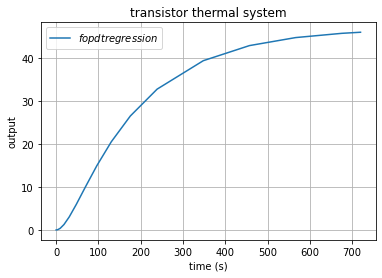

Wall time: 164 ms


In [13]:
%%time
"""
Seja kp = ganho
     teta_p = atraso
     tau_p = constante de tempo
     y/u = a / (bs^2+cs+1)
     onde a = kp, b = tau_p*theta_p e c =(theta_p + tau_p)
     Por Prof. Josenalde Oliveira - Sistemas Embarcados TADS UFRNt
"""
def fopdt_temp(time,X,kp,tau_p,theta_p,u):
    a = kp
    b = tau_p*theta_p
    c = (theta_p + tau_p)
    x1,x2 = X
    dotx1 = x2
    dotx2 = (1/b)*(-c*x2-x1+a*u) # u = força externa / sinal de controle
    return dotx1, dotx2

ti = 0
tf = 12*60
x10,x20=0,0 #assume que a mola esta em repouso x = 0, v = 0

# método de solução de ode Runge-Kutta implícito de ordem 5 RADAU
from scipy import integrate
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html

#regression model temp system
kp = 0.67
tau_p = 172.3
theta_p = 29.15

sol1 = integrate.solve_ivp(fopdt_temp, t_span=(ti, tf), y0=(x10, x20), method='Radau', args=(kp,tau_p,theta_p,70))
t1, Y1 = sol1.t, sol1.y

# Separando as soluções y1 é y, y2 é dot_y
y1_pos, y1_vel = Y1 # y1 posicao, y2 velocidade

plt.figure(1)
plt.plot(t1, y1_pos, label=r'$fopdt regression$')
plt.legend()
plt.xlabel('time (s)')
plt.title('transistor thermal system')
plt.ylabel('output')
plt.grid()
plt.show()

Sistema 2. ordem Filtro Sallen-Key Passa Baixas

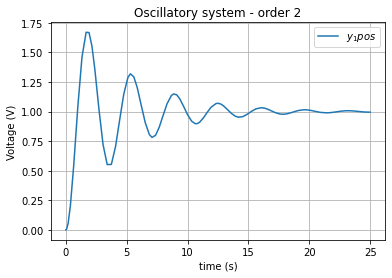

In [8]:
import matplotlib.pyplot as plt

"""
G(s) = a0 / (s^2 + a1*s + a0)
"""

def order_2_system(time,X,a0,a1,u):
    x1,x2 = X
    dotx1 = x2
    dotx2 = -a0*x1 -a1*x2 + u*a0 # u = força externa / sinal de controle
    return dotx1, dotx2

ti = 0
tf = 25
x10,x20=0,0 #assume que o sistema esta em repouso x = 0, dx = 0

# método de solução de ode Runge-Kutta implícito de ordem 5 RADAU
from scipy import integrate
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html
sol1 = integrate.solve_ivp(order_2_system, t_span=(ti, tf), y0=(x10, x20), method='Radau', args=(3.1489,0.4255,1))
t1, Y1 = sol1.t, sol1.y

# Separando as soluções y1 é y, y2 é dot_y
y1_pos, y1_vel = Y1 # y1 posicao, y2 velocidade

plt.figure(1)
plt.plot(t1, y1_pos, label=r'$y_1pos$')
plt.legend()
plt.xlabel('time (s)')
plt.title('Oscillatory system - order 2')
plt.ylabel('Voltage (V)')
plt.grid()
plt.show()

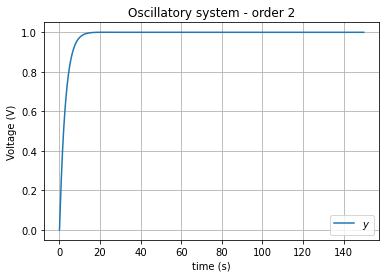

15000


In [132]:
# with PID controller
u_plot = []
y_plot = []
t_plot = []
p_plot = []
i_plot = []
d_plot = []

a0 = 3.1289
a1 = 0.4255
tSim = 150
T = 0.01 #100ms
nSamples = round(tSim/T)
kp = 1.41
tau_i = 4.04
ki = (kp/tau_i)*T
tau_d = 2.92
kd = (tau_d*kp)/T
#kd = 0
alpha = 0.455
sp = 1
x10,x20=0,0 #assume que o sistema esta em repouso x = 0, dx = 0
Xi = [x10, x20]
u = 0
y = 0
t = 0
Iterm = 0
lastY = 0

import numpy as np

A =  np.matrix([[0, 1], [-a0, -a1]])
B =  np.matrix([[0], [a0]])
C =  np.matrix('1 0')
Xi = np.matrix([[x10], [x20]])

for i in range(0,nSamples):
    #PID 
    dX = A*Xi + B*u
    Xf = Xi + T*dX
    y = Xf[0,0]
    
    e = sp - y
    P = kp*e
    Iterm = Iterm + ki*e
    dY = y - lastY
    filter_D = 1 + (alpha/T)*(-dY)
    #D = kd*(-dY) / (filter_D)
    D = kd*(-dY)
    
    u = P + Iterm + D
    
    #saturation
    if u > 3.3
    
    y_plot.append(y)
    u_plot.append(u)
    t_plot.append(t)
    
    p_plot.append(P)
    i_plot.append(Iterm)
    d_plot.append(D)
    
    lastY = y
    t = t + T
    Xi = Xf

plt.figure(1)
plt.plot(t_plot, y_plot, label=r'$y$')
plt.legend()
plt.xlabel('time (s)')
plt.title('Oscillatory system - order 2')
plt.ylabel('Voltage (V)')
plt.grid()
plt.show()
print(len(y_plot))

In [55]:
A =  np.matrix([[0, 1], [2, 3]])
B =  np.matrix([[0], [2]])
C =  np.matrix('1 0')
Xi = np.matrix([[2], [3]])
z=A*Xi + B*5
print(z)
print(z[0,0])

[[ 3]
 [23]]
3
